# Week 4 - Evaluation Metrics for Classification Models

## 4.1 - Preparation

We are going to be using a similar approach to last week to get the model running so this section is primarily copy and pasted.

In [10]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [11]:
#get data
data = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv'
!wget $data -O data.csv

--2023-10-02 08:12:42--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 977501 (955K) [text/plain]
Saving to: ‘data.csv’

data.csv            100%[===================>] 954.59K  --.-KB/s    in 0.1s    

2023-10-02 08:12:42 (7.96 MB/s) - ‘data.csv’ saved [977501/977501]



In [12]:
df = pd.read_csv('data.csv')

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [13]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [14]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [15]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [16]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

0.8034066713981547

The model is 80% accurate.

## 4.2 Accuracy and dummy model
- Evaluate the model on different thresholds
- Check thea ccuracy of dummy baselines

In [17]:
#check # of customers
len(y_val)

1409

In [18]:
#check # correctly predicted
(y_val == churn_decision).sum()

1132

In [21]:
#divide to get accuracy, the same as the mean we've done previously
1132/1409

0.8034066713981547

But remember we chose the decision threshold as 0.5, now we need to see if that was a good idea

In [29]:
#example threshold evaluation
thresholds = np.linspace(0,1,21)

scores = []

for t in thresholds:
    #grab these 2 lines from the model above
    churn_decision = (y_pred >= t) #use t instead of 0.5
    score = (y_val == churn_decision).mean() #record accuracy as score
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.509
0.10 0.591
0.15 0.666
0.20 0.710
0.25 0.739
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.766
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


The accuracy was actually the highest at the 0.5 threshold we chose

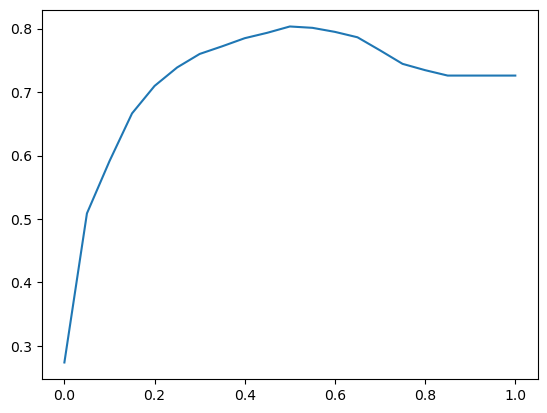

In [28]:
plt.plot(thresholds,scores)

There is a function that can do this already in scikit learn

In [31]:
#import package
from sklearn.metrics import accuracy_score

In [32]:
accuracy_score(y_val, y_pred >= 0.5) #2 metrics, actual then predictions

0.8034066713981547

In [34]:
#simplify previous function
thresholds = np.linspace(0,1,21)

scores = []

for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.509
0.10 0.591
0.15 0.666
0.20 0.710
0.25 0.739
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.766
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


In [35]:
from collections import Counter

In [37]:
Counter(y_val), 1- y_val.mean()

(Counter({0: 1023, 1: 386}), 0.7260468417317246)

Notice that in our dataset 72% of customers do not churn. Our model is 80% accurate which means only a 7% difference in accuracy from if we just predicted no customers would churn...

This is because there is an imabalance of ~3:1 non-churn to churn in our dataset. This is why accuracy can be very misleading. In the next lesson we will look at ways to handle this situation

## 4.3 Confusion table
- Different types of errors and correct decisions
- Arranging them in a table